# Step 3 - Generate Sentence Vectors

This script is to generate sentence vectors using fasttext pretrained model and run a simple test.

Prerequisites:
    To run this script, a fasttext pretrained model is needed. 
    Download link: https://fasttext.cc/docs/en/english-vectors.html
Input: 
    1. database file
    2. answer file
Output:
    1. Sentence embedding files in .npy with the same name as database file
    2. A json file (same name as the database file but with additional text '_results' in it) including all search results

In [1]:
%pylab inline
import os
import json
from PIL import Image
import utilities as util
import vectors

Populating the interactive namespace from numpy and matplotlib


c:\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [95]:
"""
Make sure these variables are correctly set.
model: file path to pretrained model
database_file: file path to database file generated from previous steps
answer_file: file path to answer file
moving_average_filter_enabled: whether or not to apply filter to sentence vectors. 
                               A separate numpy file will be generated with '_ma' in the file name
window_size: window size for the filter
"""

model = './fasttext/wiki.en' 
database_file = './data source/Life Is Strange 1/output/Life Is Strange.json'
answer_file = './data source/Life Is Strange 1/output/correct_answers.json'
moving_average_filter_enabled = True
window_size = 5


In [18]:
%%time

word_embeddings = vectors.Vectors(model)
word_embeddings.load_word_vectors(mode='fasttext');

load fasttext vec
Wall time: 7min 23s


In [96]:
"""
get sentence vectors (image keywords included)
"""

sentence_list = []
ind_dict = dict()
sentence_id = 0

with open(database_file, 'r') as f:
    json_str = f.read()
    database = json.loads(json_str)
    for file_idx, data in database.items():
        img_sessions = data['screenshots']['image_info']
        cap_sessions = data['captions']['captions']
        for session_id, img_session in img_sessions.items():
            cap_text = cap_sessions[session_id]['text']
            for frame_id, frame_info in img_session['frames'].items():
                frame_keywords = ''
                if 'image_keywords' in frame_info.keys():
                    frame_keywords = frame_info['image_keywords']
                    frame_keywords = frame_keywords.replace('_', ' ')
                    
                sentence_list.append(' '.join([cap_text, frame_keywords]))
                ind_dict[sentence_id] = (file_idx, session_id, frame_id)
                sentence_id += 1
                
print(len(ind_dict.keys()))    
print(f'number of sentences: {len(sentence_list)}')

#sentence_embedding only uses in-vocabulary words            
sentence_vectors = word_embeddings.generate_sentence_vectors(sentence_list) 
embedding_file = database_file[:database_file.rfind('.json')]
np.save(embedding_file, sentence_vectors)

with open(embedding_file + '_emb.json', 'w') as outfile:
    json.dump(ind_dict, outfile, sort_keys=False, indent=4)
    
if moving_average_filter_enabled:
    sentence_vec_filtered = util.moving_average(sentence_vectors, window_size)
    embedding_file = embedding_file + '_ma' + str(window_size)
    np.save(embedding_file, sentence_vec_filtered)
    

23149
23149


In [97]:
%%time
"""
Run test cases given a answer file including the following tests:

Testcase 1: Finding the most relevant sentences given a source sentence that appears in the real dialogues extracted. 
    This is to check whether the word embedding is correctly calculated. 
    
Testcase 2: Finding the most relevant sentences given a random combination of words. 
    This is to test whether the search can find semantically similar dialogues.
    
Testcase 3: Finding relevant images given some keywords. 
    This is to test whether the system can return useful results using the combination of sentence embeddings 
    and image keywords.

Results will be saved to a json file.
"""

if moving_average_filter_enabled:
    print(f'Moving average filter applied with window size {window_size}')
    vec_pool = sentence_vec_filtered
else:
    vec_pool = sentence_vectors

result_file = embedding_file + '_results.json'
    
with open(result_file, 'w+') as rst_f, \
     open(answer_file) as answ_f:
    answer_database = json.loads(answ_f.read())
    print(answer_file)
    result_str = rst_f.read()
    
    if len(result_str) > 0:
        result_data = json.loads(result_str)
    else:
        result_data = {}
    sentence_dir = answer_database.keys()    

    for src_sentence_id, src_sentence in enumerate(sentence_dir):
        # get similar vectors, only used for bin
        vec_sen = word_embeddings.get_sentence_vector(src_sentence, in_vocabulary = True) 
        neighbours = word_embeddings.find_nearest_neighbour(vec_sen, vec_pool)
        print(f'User Inquiry: {src_sentence}')

        result_data[src_sentence] = []
        for top_n, (nb_id, distance) in enumerate(neighbours):
            file_id = ind_dict[nb_id][0]
            session_id = ind_dict[nb_id][1]
            key = ind_dict[nb_id][2]
            result_data[src_sentence].append({'file_id':file_id, 'session_id':session_id,'frame_id': key, 'distance': distance})
    print(f'Results saved to {result_file}')
    json.dump(result_data, rst_f, indent=4)

Moving average filter applied with window size 5
./data source/Life Is Strange 1/output/correct_answers.json
User Inquiry: deduction scene
User Inquiry: rewind prompt
User Inquiry: Max fire alarm Chloe Rescue
User Inquiry: Butterfly Bucket
User Inquiry: Nathan Gun Chloe
User Inquiry: danger gun
User Inquiry: Time Freeze Kate Birds
User Inquiry: Kate Rooftop Max
User Inquiry: storm lightening
User Inquiry: storm cliff tornado
User Inquiry: toilet gun
User Inquiry: selfie classroom
User Inquiry: Max gallery
User Inquiry: Kate hospital
User Inquiry: Restaurant Jukebox
User Inquiry: swimming pool
User Inquiry: railway train stuck
User Inquiry: beacon
User Inquiry: sea sunset
User Inquiry: jukebox cafe
User Inquiry: jump okay okay I'm right here Kate
User Inquiry: Kate she did try to kill herself all
User Inquiry: Kate tried to kill herself
User Inquiry: Warren's new car
User Inquiry: Chloe Smoking
User Inquiry: Spirit Doe
User Inquiry: Jump
Results saved to ./data source/Life Is Strange 1/

User Inquiry: Butterfly Bucket
top_n: 0, distance: 0.7114937513568633, file_id: 0, session_id: 305, frame_id: 63178, captions: I shredded my photo then the butterfly, Image keywords: washbasin tub washer
top_n: 1, distance: 0.6821037590041682, file_id: 0, session_id: 149, frame_id: 34394, captions: the butterfly feels almost like a spirit, Image keywords: wardrobe suit sliding_door
top_n: 2, distance: 0.6776490485848753, file_id: 0, session_id: 305, frame_id: 63059, captions: I shredded my photo then the butterfly, Image keywords: tub washbasin bathtub
top_n: 3, distance: 0.6737032837146629, file_id: 0, session_id: 305, frame_id: 63297, captions: I shredded my photo then the butterfly, Image keywords: shower_curtain spotlight stage
top_n: 4, distance: 0.6701914662634259, file_id: 0, session_id: 144, frame_id: 33652, captions: whoa where did that butterfly come from, Image keywords: cash_machine paper_towel backpack
top_n: 5, distance: 0.6531486832516556, file_id: 3, session_id: 576, fr

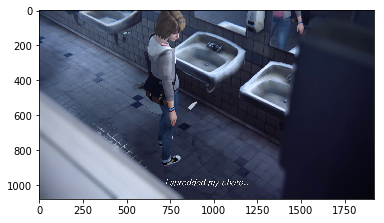

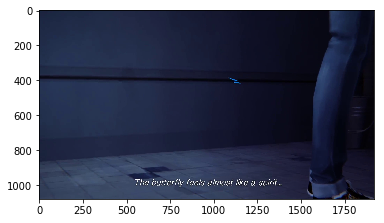

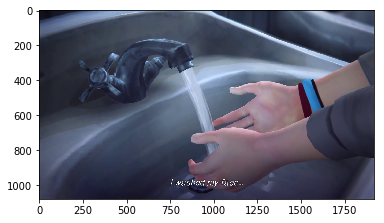

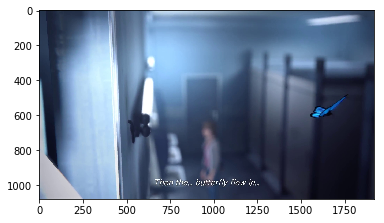

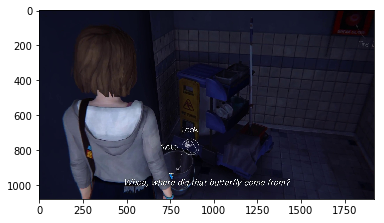

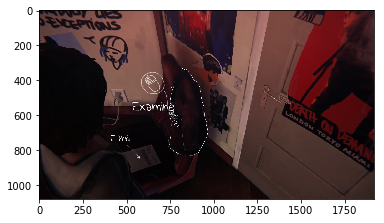

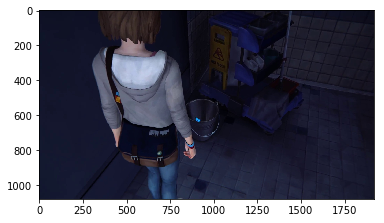

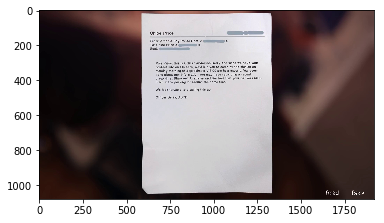

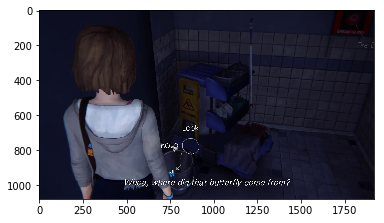

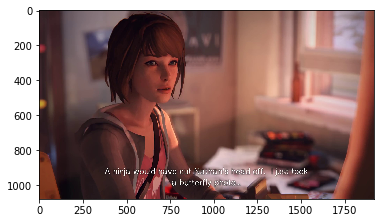

In [69]:
"""
Print out search results. 
To display only one result, just comment out line 7 and use line 6 instead, and 
replace that string with another inquiry listed in the answer file.
"""
sentence_dir = ["Butterfly Bucket"]
#sentence_dir = answer_database.keys()
top_n_neighbours = 10
if len(sentence_dir) > 1:
    fig, axes = plt.subplots(top_n_neighbours, len(sentence_dir), figsize=(35, 25), subplot_kw={'xticks': [], 'yticks': []})

for src_sentence_id, src_sentence in enumerate(sentence_dir):
    print(f'User Inquiry: {src_sentence}')
    for top_n, rst in enumerate(result_data[src_sentence][:top_n_neighbours]):
        distance = rst['distance']
        file_id = rst['file_id']
        session_id = rst['session_id']
        img_folder = database[file_id]['screenshots']['image_folder']
        img_sessions = database[file_id]['screenshots']['image_info']
        frame_id = rst['frame_id']
        img_file = img_sessions[session_id]['frames'][frame_id]['image_file']
        img_file = os.path.join(img_folder, img_file)
        image = Image.open(img_file) 
        cap_text = database[file_id]['captions']['captions'][session_id]['text']
        img_keywords = ''
        if 'image_keywords' in img_sessions[session_id]['frames'][frame_id].keys():
            img_keywords = img_sessions[session_id]['frames'][frame_id]['image_keywords']
        print(f'top_n: {top_n}, distance: {distance}, file_id: {file_id}, session_id: {session_id}, frame_id: {frame_id}, captions: {cap_text}, Image keywords: {img_keywords}')
        
        title = f'{file_id}:{key}'
        if len(sentence_dir) > 1:
            axes[top_n][src_sentence_id].imshow(np.asarray(image))
            axes[top_n][src_sentence_id].set_title(title)
        else:
            plt.figure()
            plt.imshow(image)
    
if len(sentence_dir) > 1:
    fig.tight_layout()       
    plt.show()